## Evaluation

The result is evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:

$$
MAE = \frac{1}{n}\sum_{i=1}{n}|y_i - x_i|
$$

Where:
- n is the total number of data points.
- y_i is the predicted value for data point i.
- x_i is the observed value for data point i.

In [1]:
import pickle

with open('../data/preprocessed/train_val_dataset.pkl', 'rb') as file:
    train_val_dataset = pickle.load(file)
    
with open('../data/preprocessed/test_dataset.pkl', 'rb') as file:
    test_dataset = pickle.load(file)

X_other, y_other, groups_other = train_val_dataset['X_other'], train_val_dataset['y_other'], train_val_dataset['groups_other']
X_test, y_test, groups_test, submission_id = test_dataset['X_test'], test_dataset['y_test'], test_dataset['groups_test'], test_dataset['submission_id']

# Baseline Score:

Baseline is achieved by assign the target mean of each stock in the test set as the predition.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

df_test = X_test.copy()
df_test['y_true'] = y_test
baseline = df_test.groupby('stock_id').y_true.mean().reset_index().rename(columns={'y_true': 'y_pred'})
df_test = pd.merge(df_test, baseline, how='left', on='stock_id')

print('MAE score:', mean_absolute_error(df_test['y_true'], df_test['y_pred']))

MAE score: 6.883545637551946


# Model Scores:

## XGBoost

In [45]:
import numpy as np

with open('../result/xgboost/xgboost_scores.pkl', 'rb') as file:
    scores_xgb = pickle.load(file)
with open('../result/xgboost/xgboost_pred_results.pkl', 'rb') as file:
    pred_results_xgb = pickle.load(file)
with open('../result/xgboost/xgboost_best_models.pkl', 'rb') as file:
    best_models_xgb = pickle.load(file)

test_scores_xgb = scores_xgb['Test_Scores']
best_model_xgb = best_models_xgb[-1]
print(test_scores_xgb)
print('mean MAE:', np.mean(test_scores_xgb), 'std MAE:', np.std(test_scores_xgb))

[07:42:25] WARNING: D:\bld\xgboost-split_1693020860727\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[6.73876265 6.74234162 6.74128729 6.74073149]
mean MAE: 6.740780763151302 std MAE: 0.0013007745099942825


## Lasso Reduced Features:

In [36]:
with open('../result/linear_reduced_feature/lasso_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_lasso = pickle.load(file)
with open('../result/linear_reduced_feature/lasso_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_lasso = pickle.load(file)

print(test_scores_lasso)
print('mean MAE:', np.mean(test_scores_lasso), 'std MAE:', np.std(test_scores_lasso))

[6.7354542  6.7353624  6.73541976 6.73531435]
mean MAE: 6.735387677419143 std MAE: 5.355157758185661e-05


## Ridge RF

In [5]:
with open('../result/linear_reduced_feature/ridge_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_ridge = pickle.load(file)
with open('../result/linear_reduced_feature/ridge_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_ridge = pickle.load(file)

print(test_scores_ridge)
print('mean MAE:', np.mean(test_scores_ridge), 'std MAE:', np.std(test_scores_ridge))

[6.75691924 6.75678804 6.75987626 6.75729838]
mean MAE: 6.757720479085643 std MAE: 0.001258666177864995


## XGB Reduced Features

In [6]:
with open('../result/xgboost_reduced_feature/xgb_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_rf_xgb = pickle.load(file)
with open('../result/xgboost_reduced_feature/xgb_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_rf_xgb = pickle.load(file)

print(test_scores_rf_xgb)
print('mean MAE:', np.mean(test_scores_rf_xgb), 'std MAE:', np.std(test_scores_rf_xgb))

[6.74028892 6.73927359 6.73884638 6.73712802]
mean MAE: 6.738884228337913 std MAE: 0.0011413218275947614


## Mean Std

Text(11.527545747939529, 0.5, 'Mean (Std) of Mean Absolute Error')

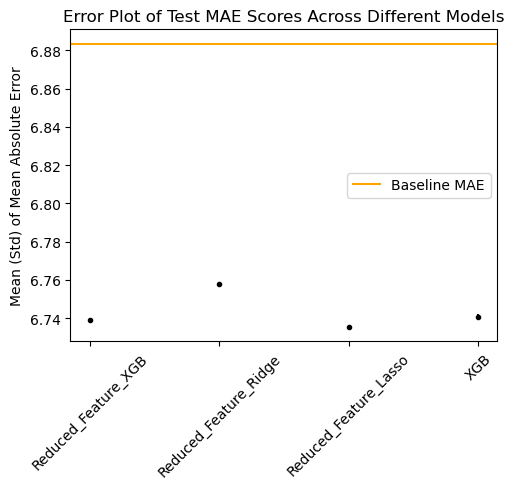

In [7]:
import matplotlib.pylab as plt

means = [np.mean(test_scores_rf_xgb),
         np.mean(test_scores_ridge),
         np.mean(test_scores_lasso),
         np.mean(test_scores_xgb)]
std_devs = [np.std(test_scores_rf_xgb),
            np.std(test_scores_ridge),
            np.std(test_scores_lasso),
            np.std(test_scores_xgb)]
baseline_mae_score = 6.883545637551946

labels = ['Reduced_Feature_XGB', 'Reduced_Feature_Ridge', 'Reduced_Feature_Lasso', 'XGB']

plt.figure(figsize=(5, 5))
plt.errorbar(labels, means, yerr=std_devs, fmt='.k')
plt.axhline(y=baseline_mae_score, color='orange', linestyle='-', label='Baseline MAE')
plt.xticks(rotation=45)
plt.title("Error Plot of Test MAE Scores Across Different Models")
plt.tight_layout()
plt.legend()
plt.savefig('../figures/evaluation/error_plot_test_scores.png', dpi=300, bbox_inches='tight')
plt.ylabel("Mean (Std) of Mean Absolute Error")

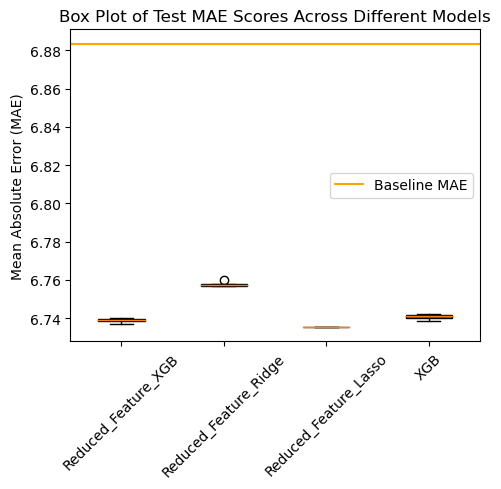

In [8]:
data = [test_scores_rf_xgb, test_scores_ridge, test_scores_lasso, test_scores_xgb]

plt.figure(figsize=(5, 5))
plt.boxplot(data, patch_artist=True)
plt.axhline(y=baseline_mae_score, color='orange', linestyle='-', label='Baseline MAE')

plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Box Plot of Test MAE Scores Across Different Models')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/evaluation/box_plot_test_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter Plots
For each model, we plot the predictions using 4-th fold results.

In [28]:
predictions = pd.DataFrame({'target': y_test.values.reshape(-1),
                            'pred_xgb_reduced_feature': pred_results_rf_xgb[-1].values.reshape(-1),
                            'pred_lasso_reduced_feature': pred_results_lasso[-1].values.reshape(-1),
                            'pred_ridge_reduced_feature': pred_results_ridge[-1].values.reshape(-1),
                            'pred_xgboost': pred_results_xgb[-1]})

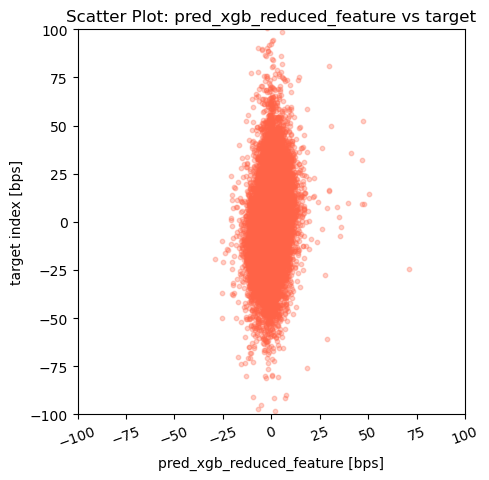

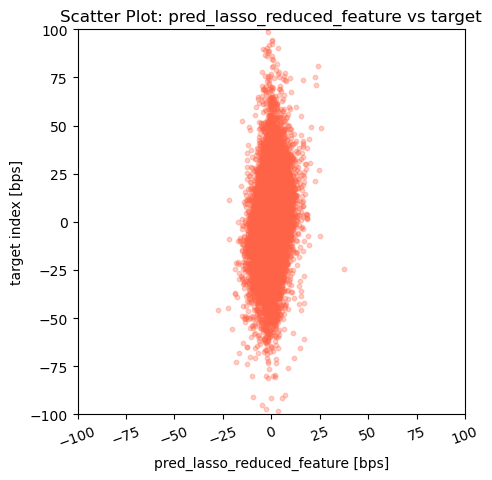

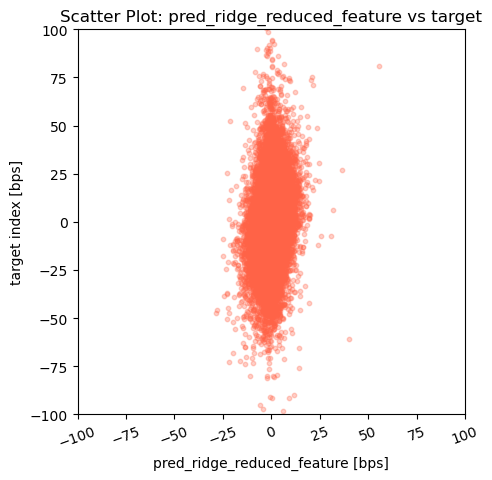

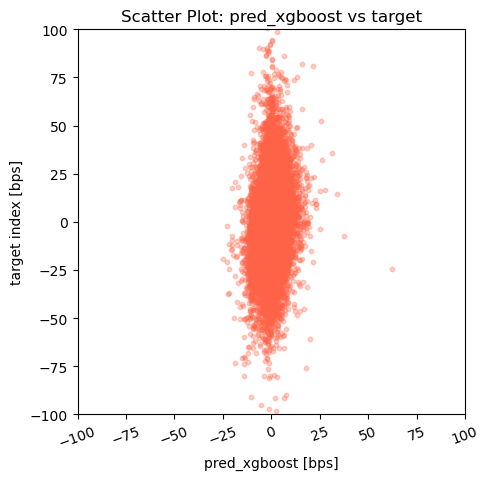

In [33]:
for pred in ['pred_xgb_reduced_feature', 'pred_lasso_reduced_feature',
             'pred_ridge_reduced_feature', 'pred_xgboost']:
    predictions.plot.scatter(pred, 'target', figsize=(5,5), color='tomato', alpha=0.3, s=10)
    plt.xlim([-100, 100])  
    plt.ylim([-100, 100])  
    plt.xticks(rotation=20)
    plt.xlabel(f'{pred} [bps]')
    plt.ylabel('target index [bps]')
    plt.title(f'Scatter Plot: {pred} vs target')
    plt.savefig(f'../figures/evaluation/scatter_plot_{pred}_vs_target.png', dpi=300, bbox_inches='tight')
    plt.show()

# Feature Importances

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info)

# collect which encoder to use on each feature
onehot_ftrs = ['imbalance_buy_sell_flag', 'stock_id']
std_ftrs = ['seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 
            'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 
            'wap', 'lagged_target_1d_0', 'lagged_target_1d_10', 'lagged_target_1d_20', 
            'lagged_target_1d_30', 'lagged_target_1d_40', 'lagged_target_1d_50', 
            'lagged_target_1d_60', 'lagged_target_1d_70', 'lagged_target_1d_80', 
            'lagged_target_1d_90', 'lagged_target_1d_100', 'lagged_target_1d_110', 
            'lagged_target_1d_120', 'lagged_target_1d_130', 'lagged_target_1d_140', 
            'lagged_target_1d_150', 'lagged_target_1d_160', 'lagged_target_1d_170', 
            'lagged_target_1d_180', 'lagged_target_1d_190', 'lagged_target_1d_200', 
            'lagged_target_1d_210', 'lagged_target_1d_220', 'lagged_target_1d_230', 
            'lagged_target_1d_240', 'lagged_target_1d_250', 'lagged_target_1d_260', 
            'lagged_target_1d_270', 'lagged_target_1d_280', 'lagged_target_1d_290', 
            'lagged_target_1d_300', 'lagged_target_1d_310', 'lagged_target_1d_320', 
            'lagged_target_1d_330', 'lagged_target_1d_340', 'lagged_target_1d_350', 
            'lagged_target_1d_360', 'lagged_target_1d_370', 'lagged_target_1d_380', 
            'lagged_target_1d_390', 'lagged_target_1d_400', 'lagged_target_1d_410', 
            'lagged_target_1d_420', 'lagged_target_1d_430', 'lagged_target_1d_440', 
            'lagged_target_1d_450', 'lagged_target_1d_460', 'lagged_target_1d_470', 
            'lagged_target_1d_480', 'lagged_target_1d_490', 'lagged_target_1d_500', 
            'lagged_target_1d_510', 'lagged_target_1d_520', 'lagged_target_1d_530', 
            'lagged_target_1d_540', 'volume', 'mid_price', 'liquidity_imbalance', 
            'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb', 
            'reference_price_near_price_imb', 'reference_price_ask_price_imb', 
            'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 
            'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 
            'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 
            'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 
            'price_pressure', 'market_urgency', 'depth_pressure', 'all_prices_mean', 
            'all_sizes_mean', 'all_prices_std', 'all_sizes_std', 'all_prices_skew', 
            'all_sizes_skew', 'all_prices_kurt', 'all_sizes_kurt', 'dow', 'seconds', 'minute']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
prep = Pipeline(steps=[('preprocessor', preprocessor)])

len_group_other = groups_other.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group_other*0.25), n_splits=4)

for i_train, i_val in gts.split(X_other, y_other, groups_other):
    print("\t Train index:", i_train, "Val index:", i_val)
    print("\t Train size:", len(i_train), "Val size:", len(i_val))
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]
    
    X_train_preprocessed = prep.fit_transform(X_train)
    feature_names = prep.get_feature_names_out()
    X_test_preprocessed = prep.transform(X_test)
    df_test = pd.DataFrame(data = X_test_preprocessed, columns = feature_names, index=y_test.index)

	 Train index: [     0      1      2 ... 743181 743182 743183] Val index: [ 743184  743185  743186 ... 1002231 1002232 1002233]
	 Train size: 743184 Val size: 259050
	 Train index: [ 10505  10506  10507 ... 753961 753962 753963] Val index: [ 753964  753965  753966 ... 1013066 1013067 1013068]
	 Train size: 743459 Val size: 259105
	 Train index: [ 21010  21011  21012 ... 764741 764742 764743] Val index: [ 764744  764745  764746 ... 1023901 1023902 1023903]
	 Train size: 743734 Val size: 259160
	 Train index: [ 31515  31516  31517 ... 775521 775522 775523] Val index: [ 775524  775525  775526 ... 1034736 1034737 1034738]
	 Train size: 744009 Val size: 259215
